In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
#unseen validation data

#data = pd.read_csv("traj_data_v2_validation.csv")
data = pd.read_csv("traj_data_v2_100_seq.csv")

data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,149950.000000,151.187826,-33.894480,0.000001,0.000001
std,86602.684716,86602.679905,0.002236,0.001248,0.000045,0.000022
min,0.000000,0.000000,151.184833,-33.895620,-0.000128,-0.000090
25%,74999.750000,74975.000000,151.186473,-33.895169,-0.000023,-0.000012
50%,149999.500000,149950.000000,151.187480,-33.894783,0.000000,0.000000
75%,224999.250000,224925.000000,151.188458,-33.894342,0.000026,0.000015
max,299999.000000,299900.000000,151.194604,-33.889197,0.000133,0.000089


In [3]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [4]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = 100, input_len = 20)

In [5]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(2100, 1, 20)
(2100, 1, 78)
(2100, 20, 1)
(2100, 78, 1)
(900, 1, 20)
(900, 1, 78)
(900, 20, 1)
(900, 78, 1)


In [6]:
model = keras.models.load_model('LSTM_100seq.h5')

In [7]:
input_len = 20
target_len = 78
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        data = data_source_inputs[i,:,:]
        res = model.predict(data_source_inputs[i:i+1])
        ground_truths.append(data_source_targets[i].squeeze().tolist())
        predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
        inputs.append(data.squeeze().tolist())
            
    return inputs, ground_truths, predictions

In [8]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [9]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds)
    err += dist
  return (err / len(targets))

In [10]:
calculate_eucledian_mse(target_list, preds_list)

TypeError: unsupported operand type(s) for %: 'list' and 'int'

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
  
  for i in range(0, 100, 1):
    print(i)
    plt.figure(figsize=(6,6))
    inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    
    for inp in inputs:
      x = inp % 100
      y = inp / 100 
      xy_inputs.append([x, y])
    
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='black')
    plt.scatter(x_pred,y_pred, color='r')

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()


0


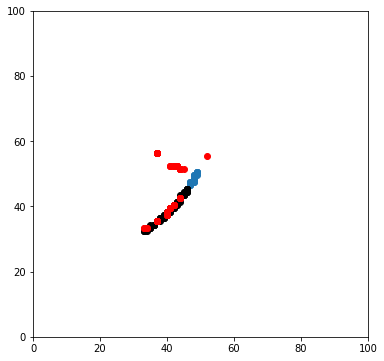

1


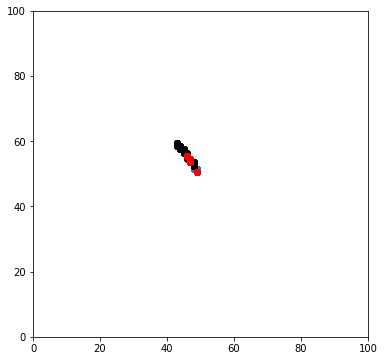

2


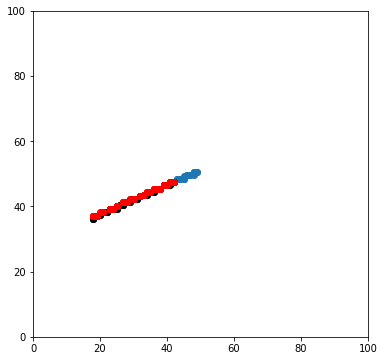

3


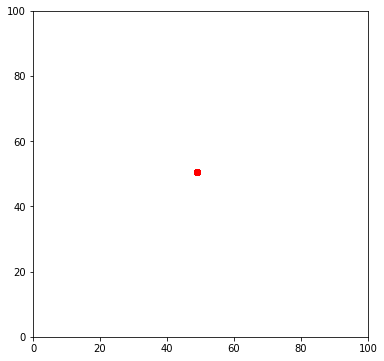

4


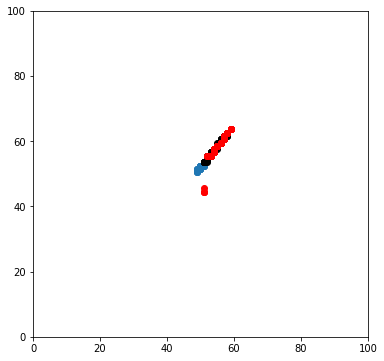

5


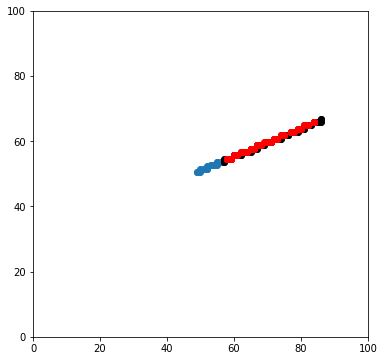

6


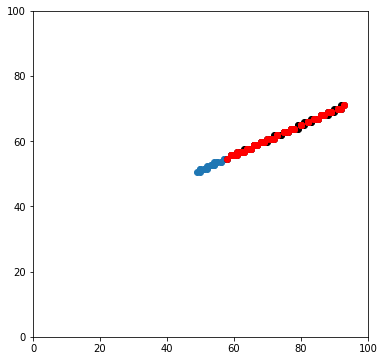

7


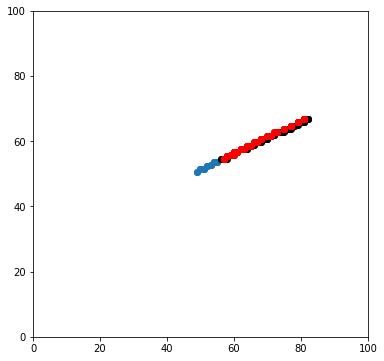

8


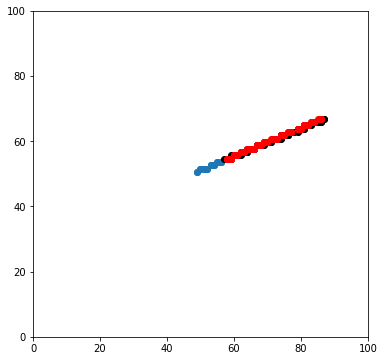

9


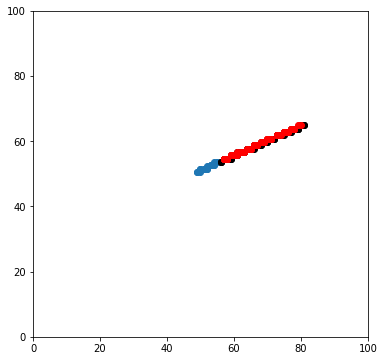

10


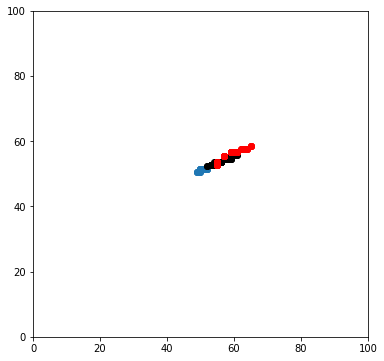

11


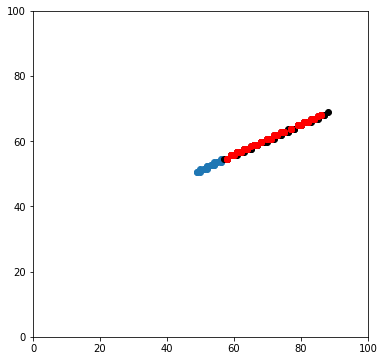

12


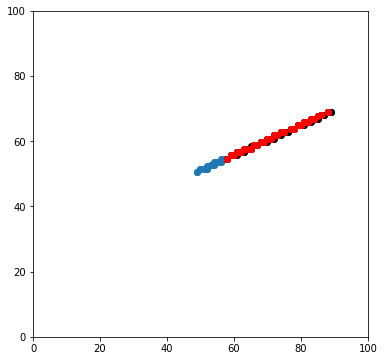

13


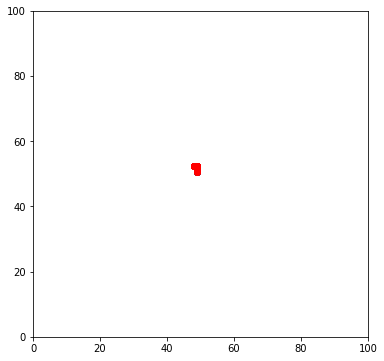

14


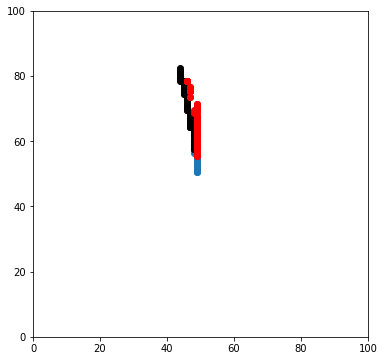

15


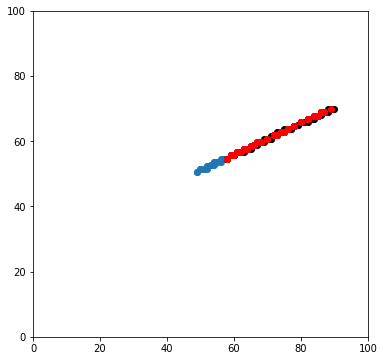

16


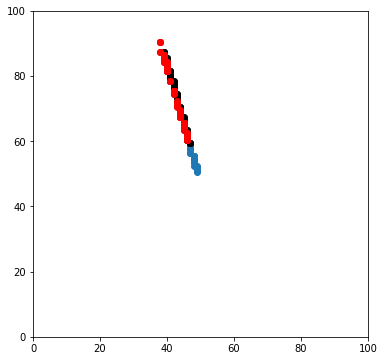

17


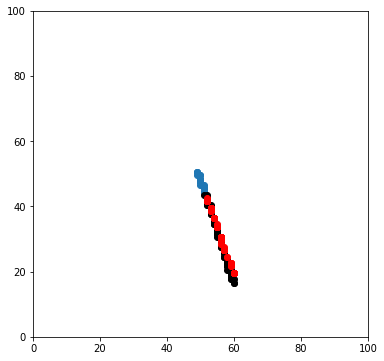

18


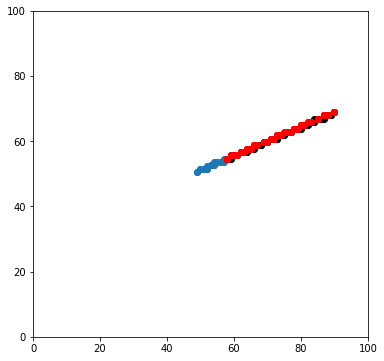

19


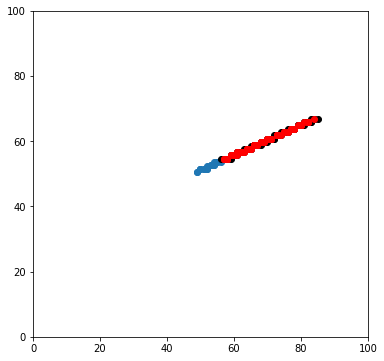

20


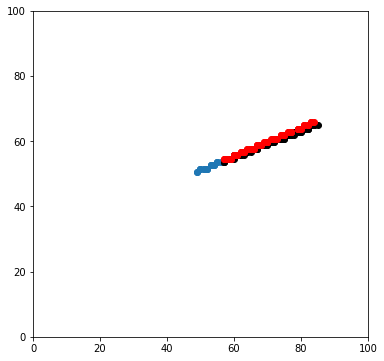

21


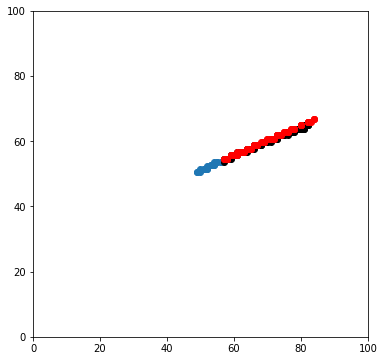

22


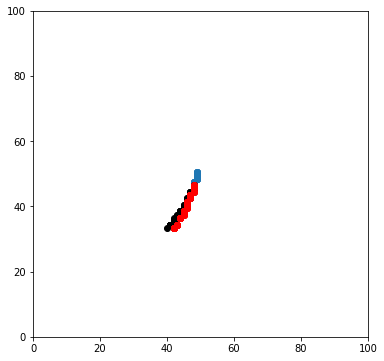

23


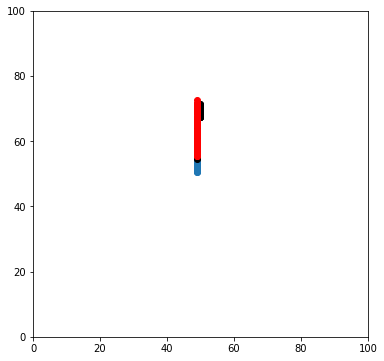

24


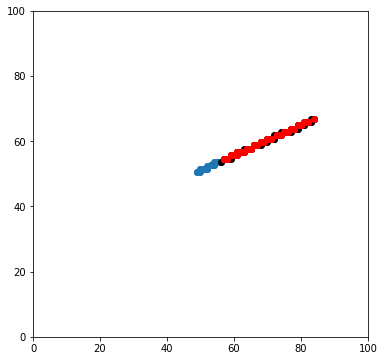

25


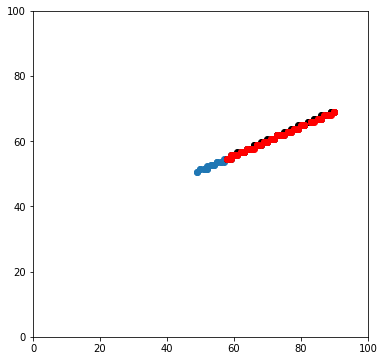

26


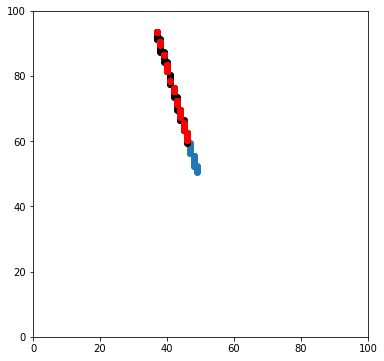

27


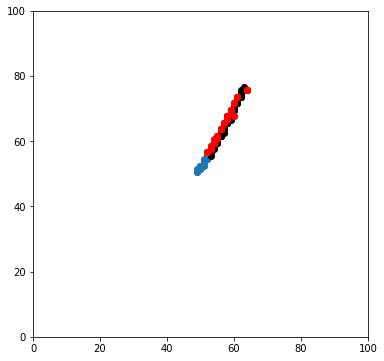

28


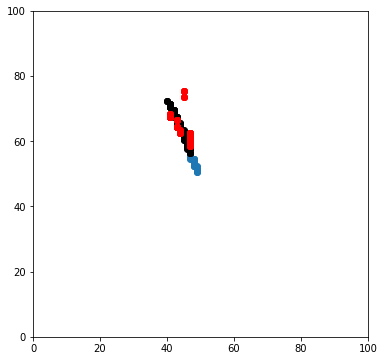

29


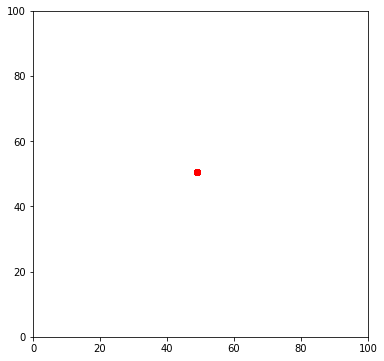

30


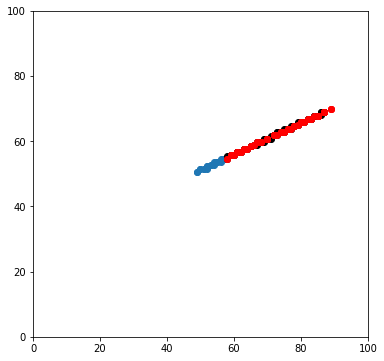

31


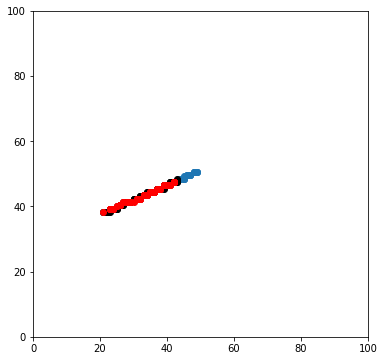

32


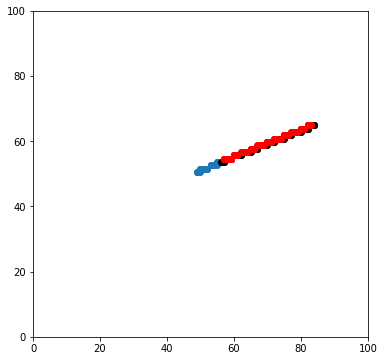

33


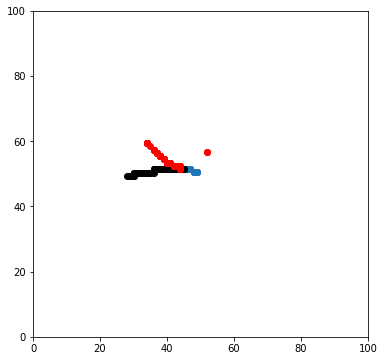

34


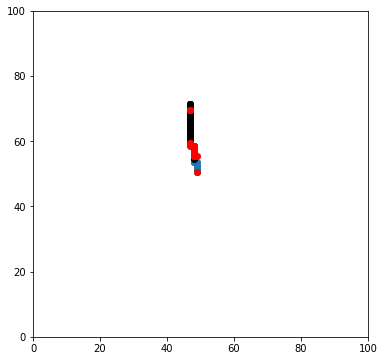

35


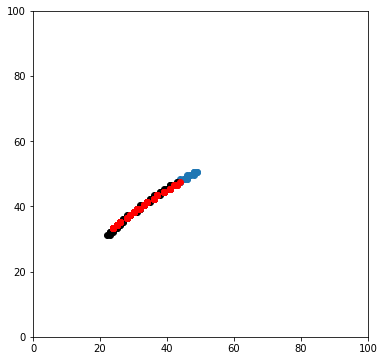

36


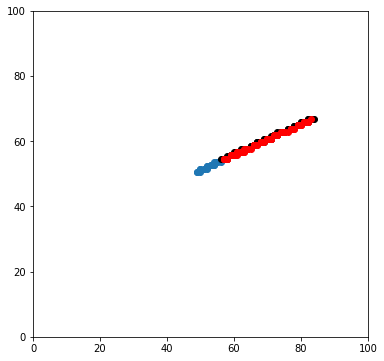

37


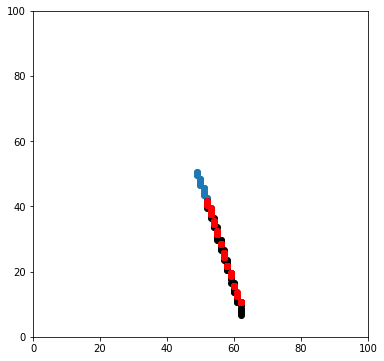

38


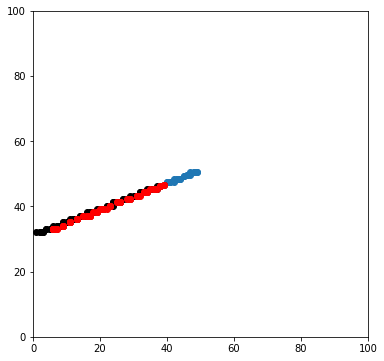

39


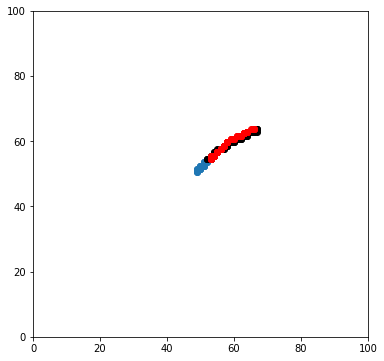

40


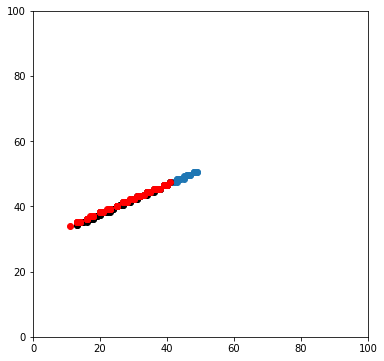

41


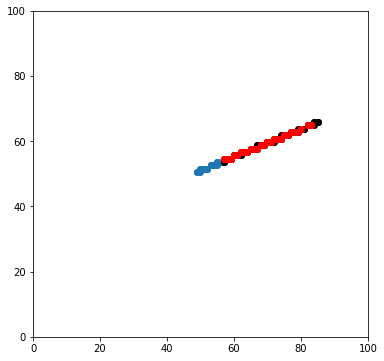

42


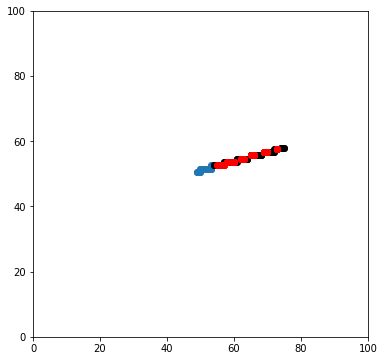

43


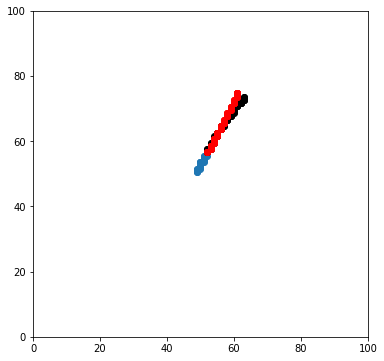

44


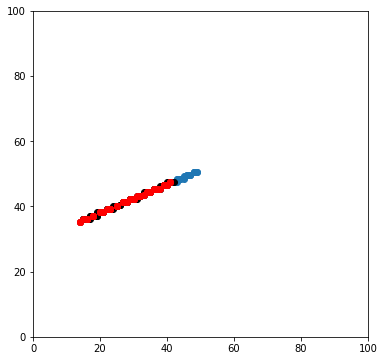

45


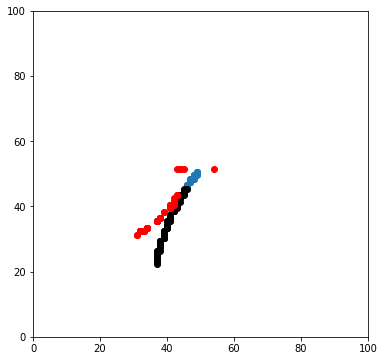

46


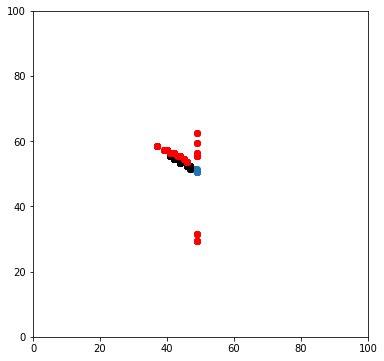

47


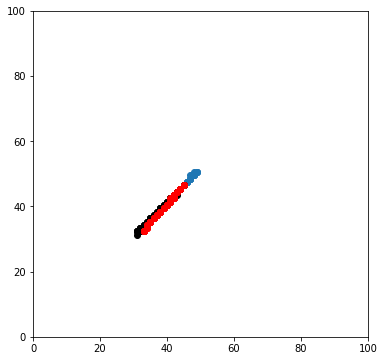

48


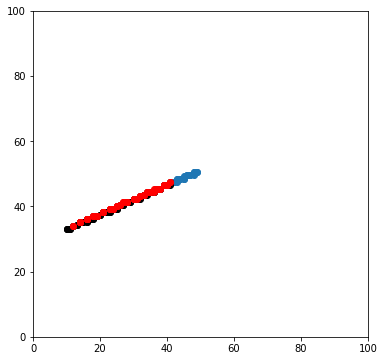

49


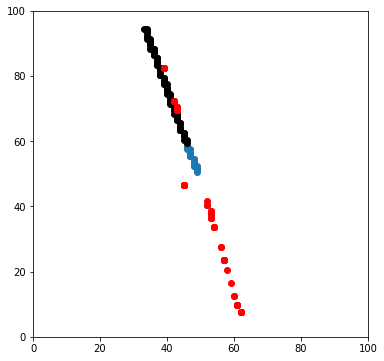

50


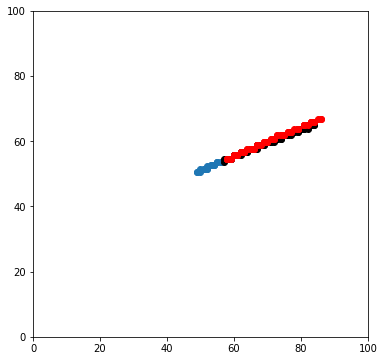

51


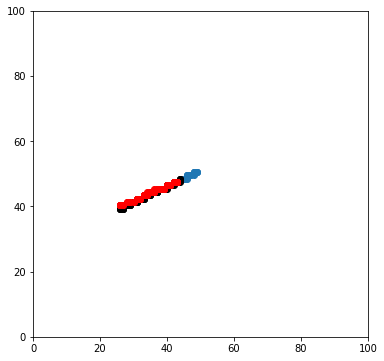

52


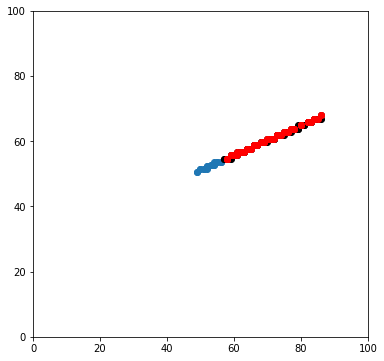

53


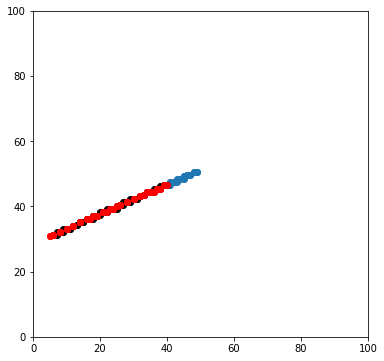

54


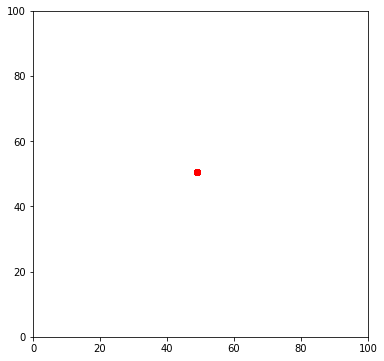

55


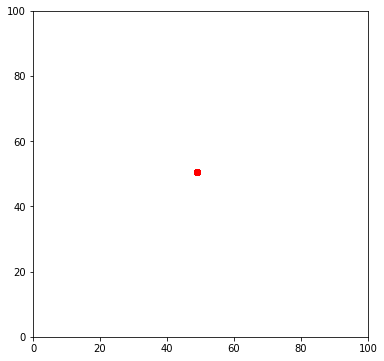

56


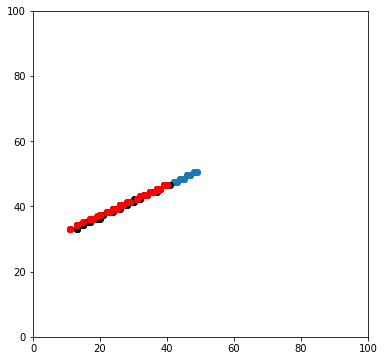

57


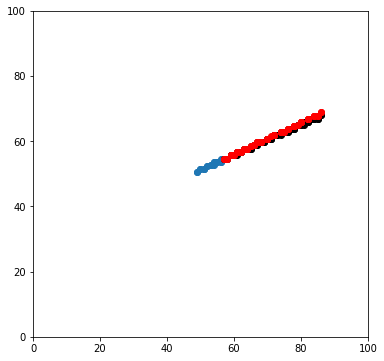

58


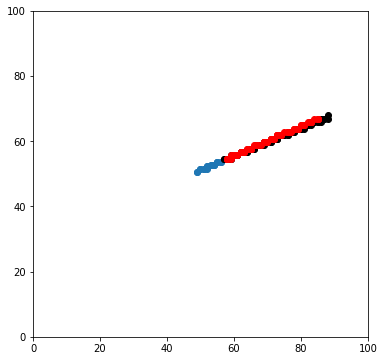

59


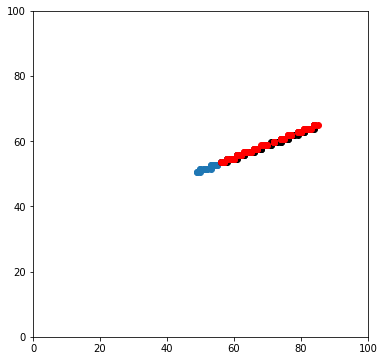

60


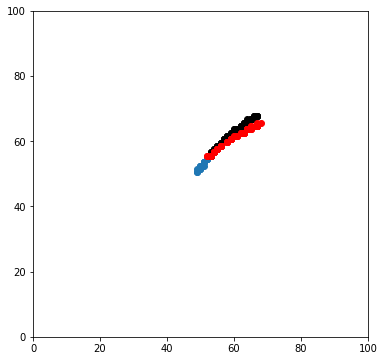

61


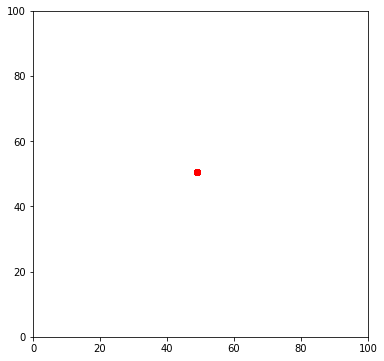

62


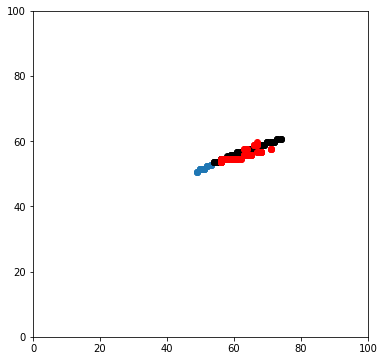

63


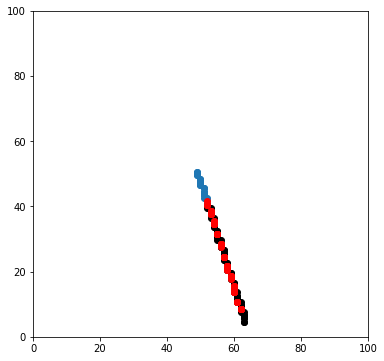

64


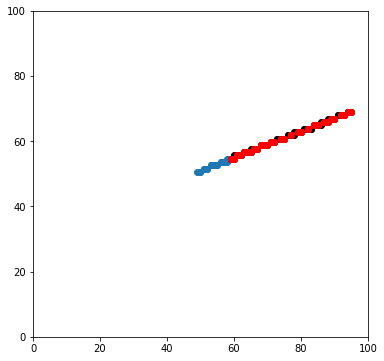

65


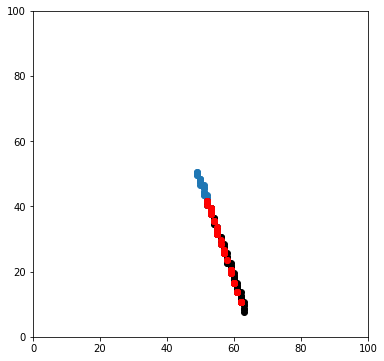

66


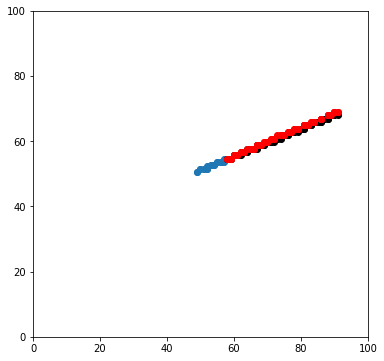

67


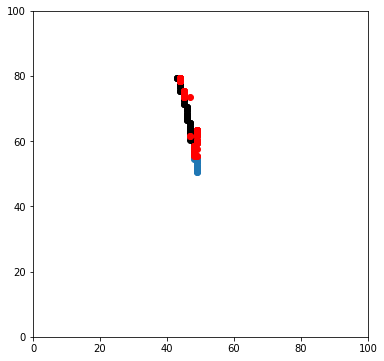

68


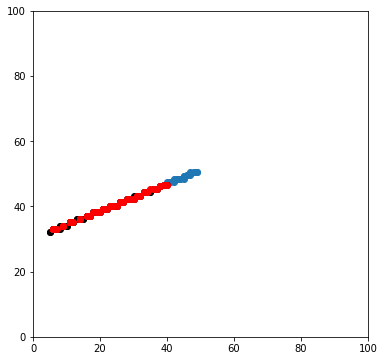

69


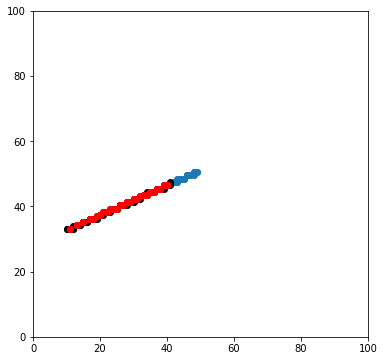

70


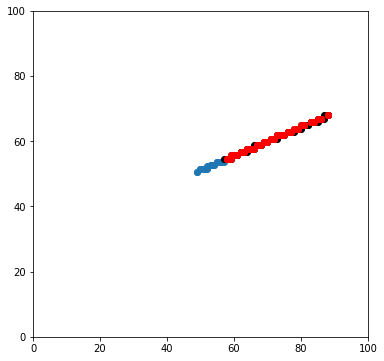

71


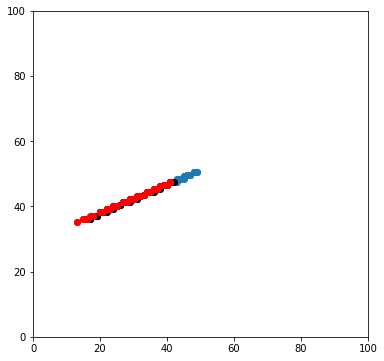

72


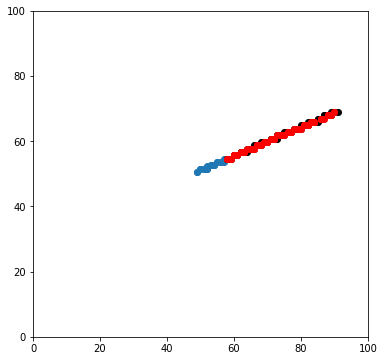

73


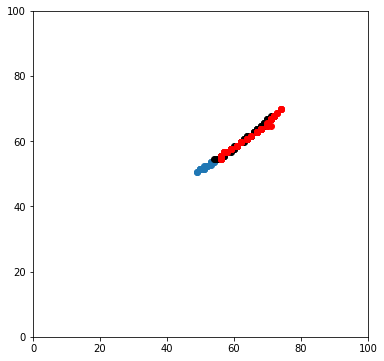

74


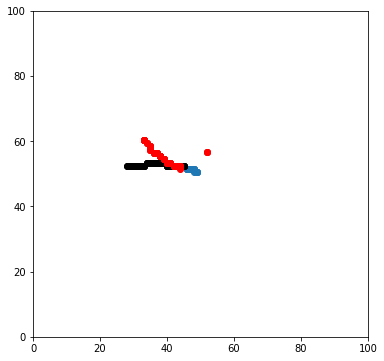

75


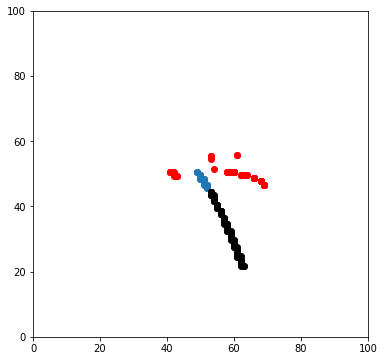

76


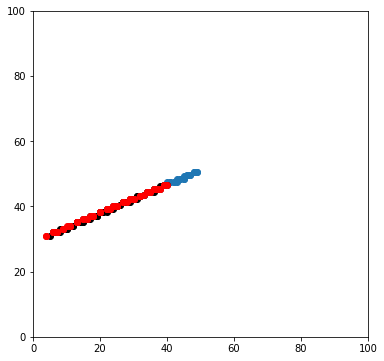

77


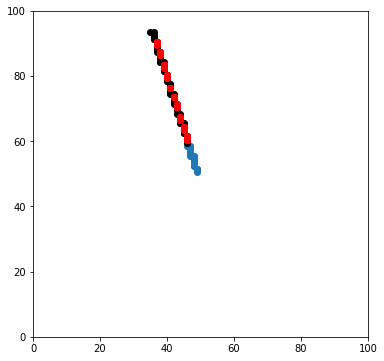

78


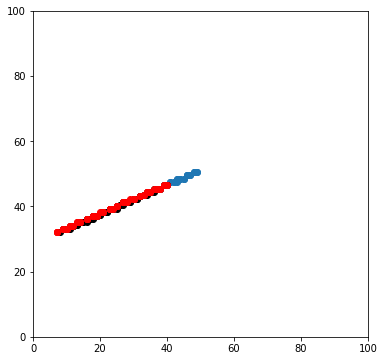

79


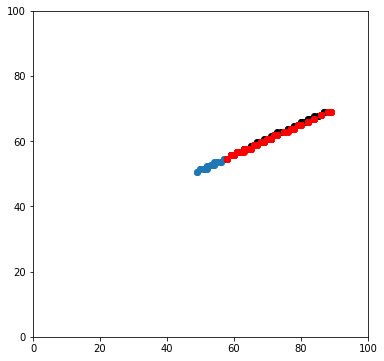

80


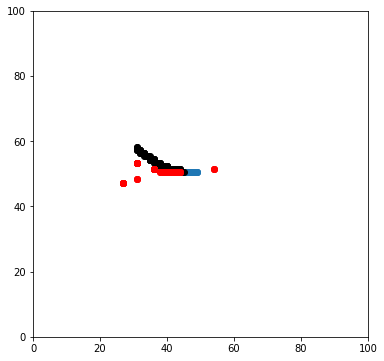

81


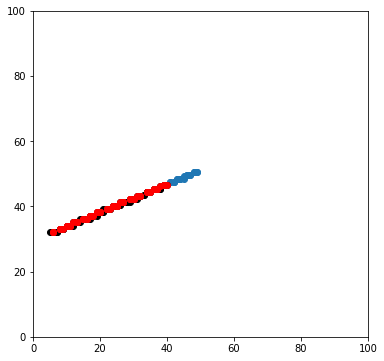

82


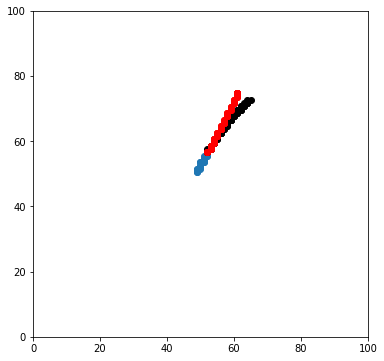

83


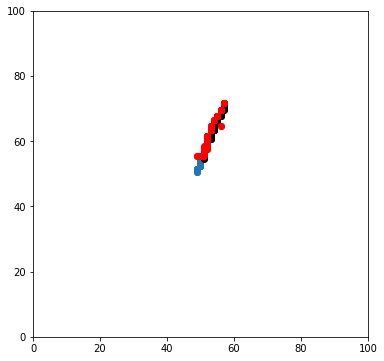

84


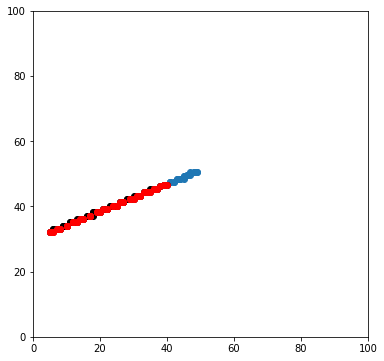

85


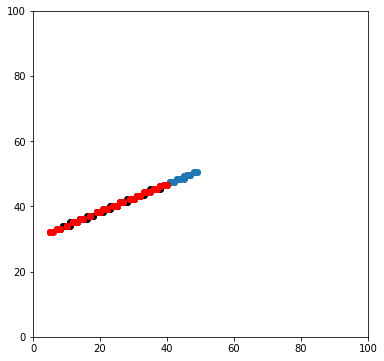

86


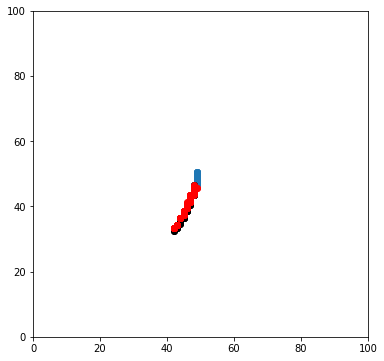

87


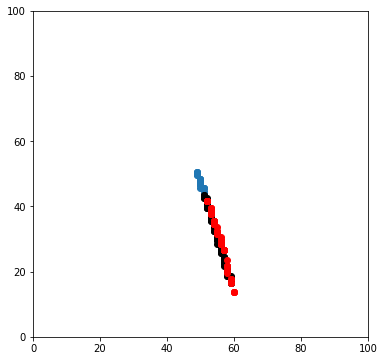

88


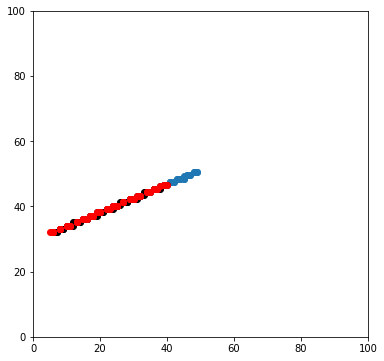

89


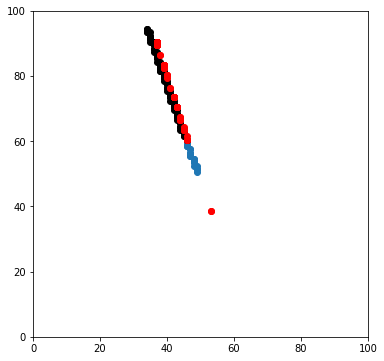

90


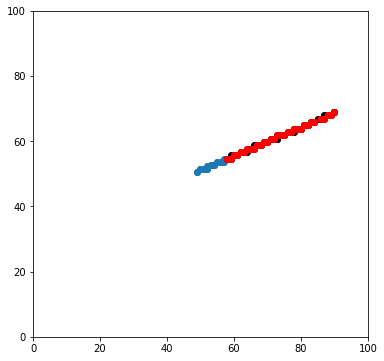

91


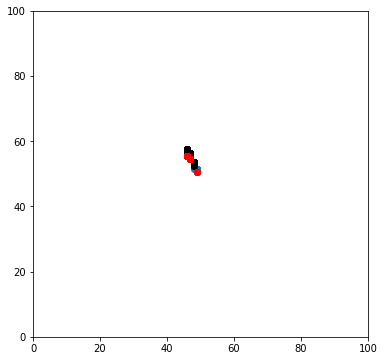

92


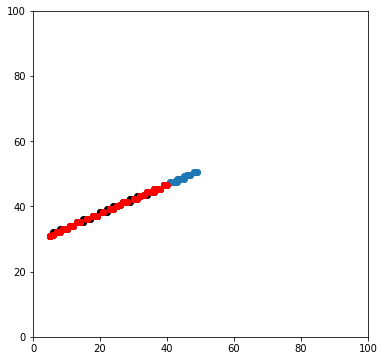

93


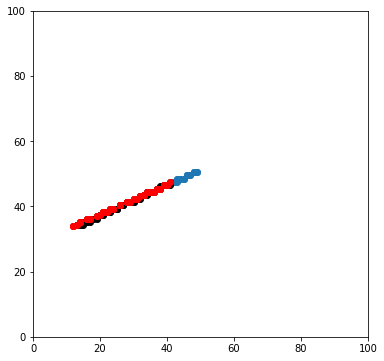

94


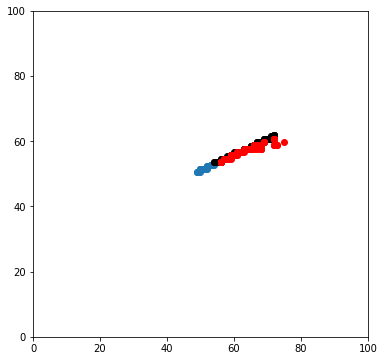

95


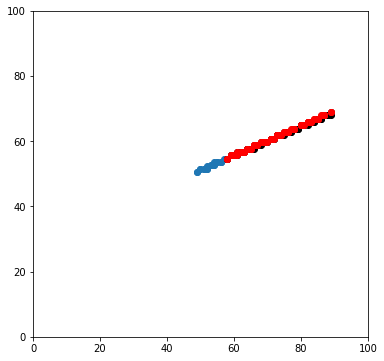

96


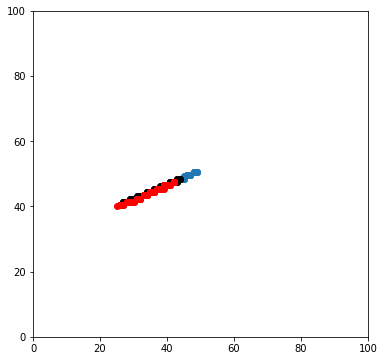

97


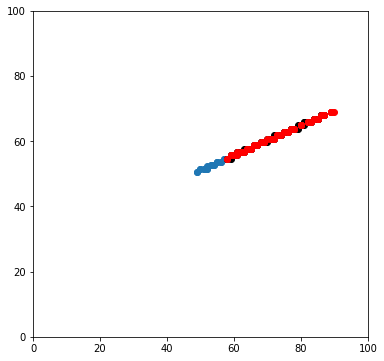

98


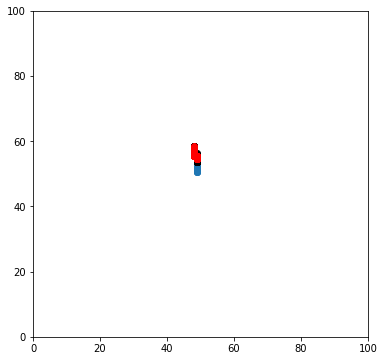

99


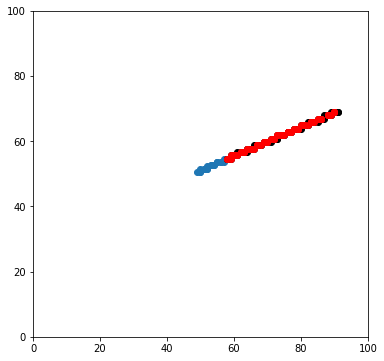

In [20]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [103]:
inputs_list

[[[4950],
  [4949],
  [4948],
  [4948],
  [4947],
  [4846],
  [4846],
  [4845],
  [4844],
  [4743],
  [4743],
  [4742],
  [4641],
  [4740],
  [4640],
  [4639],
  [4638],
  [4538],
  [4537],
  [4536]],
 [[4950],
  [5050],
  [5150],
  [5249],
  [5349],
  [5449],
  [5548],
  [5648],
  [5748],
  [5848],
  [5848],
  [5947],
  [6047],
  [6147],
  [6247],
  [6346],
  [6446],
  [6546],
  [6646],
  [6745]],
 [[4950],
  [5050],
  [5049],
  [5149],
  [5149],
  [5249],
  [5249],
  [5349],
  [5348],
  [5448],
  [5448],
  [5548],
  [5548],
  [5548],
  [5647],
  [5647],
  [5747],
  [5747],
  [5747],
  [5847]],
 [[4950],
  [4949],
  [4949],
  [4948],
  [4948],
  [4847],
  [4847],
  [4846],
  [4846],
  [4845],
  [4745],
  [4744],
  [4744],
  [4743],
  [4743],
  [4642],
  [4642],
  [4641],
  [4641],
  [4640]],
 [[4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [495